In [3]:
import matplotlib.pyplot as plot
import numpy as np
import math
from random import random
import scipy.stats as sp
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split

In [182]:
def stimulatedSpikeTrain(firingRate, ms, stimRate, ini, fin):
    spkT = []
    for i in range(ms):
        x = random()
        if i >= ini and i <= fin:
            if x < stimRate * 0.001:
                spkT.append(1)
            else:
                spkT.append(0)
        else:
            if x < firingRate * 0.001:
                spkT.append(1)
            else:
                spkT.append(0)
    return spkT


def generateExperimentData(nTrials, binSize, firingRate, ms, stimRate, ini, fin):
    experimentData = []
    baselineSpk = []
    stimulusSpk = []

    for i in range(nTrials):
        spkT = stimulatedSpikeTrain(firingRate, ms, stimRate, ini, fin)
        experimentData.append(spkT)

        for j in range(int(len(spkT) / binSize)):
            bin = spkT[j * binSize:(j + 1) * binSize]

            if j*binSize >= ini and j*binSize < fin:
                stimulusSpk.append(bin.count(1))
            else:
                baselineSpk.append(bin.count(1))

    return experimentData, baselineSpk, stimulusSpk

def plotExperimentData(expData, filename):
    fig, ax = plot.subplots()
    for i in range(len(expData)):
        spkTimes = [i for i, x in enumerate(expData[i]) if x == 1]
        ax.vlines(spkTimes, i - 0.3, i + 0.3)
    ax.set_xlabel('Tiempo (ms)')
    ax.set_ylabel('Nº de prueba')
    ax.set_title('Tiempos de pulso')
    ax.set_xlim([0, len(expData[0])])
    plot.axvline(x=1000, color="Red")
    plot.axvline(x=1500, color="Red")
    #plot.show()
    plot.savefig(filename, dpi=300)
    plot.clf()

In [10]:
exp, bs, st = generateExperimentData(10, 100, 10, 2000, 35, 1000, 1500)

In [30]:
def bayesianEstimator(bsSpikes, stSpikes, umbral):
    baselineProbs = []
    stimulusProbs = []

    for i in range(len(stSpikes)):
        if i >= 0:
            if stSpikes[i] != 0:
                if stSpikes[i]/np.sum(stSpikes) >= umbral:
                    stimulusProbs.append(stSpikes[i] / np.sum(stSpikes))
                    try:
                        baselineProbs.append(bsSpikes[i] / np.sum(bsSpikes))
                    except IndexError:
                        baselineProbs.append(0)

    return  1 -  np.prod(baselineProbs)/np.prod(stimulusProbs)

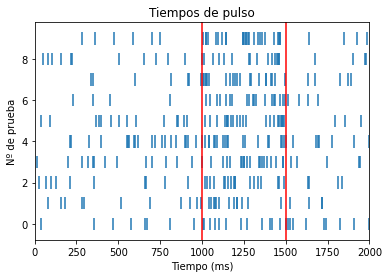

In [17]:
plotExperimentData(exp)

In [185]:
print(bayesianEstimator(bs, st, 0.05))

1.0


In [158]:
exp2, bs2, st2 = generateExperimentData(5, 100, 30, 2000, 35, 1000, 1500)

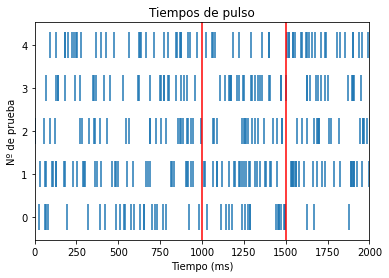

In [159]:
plotExperimentData(exp2)

In [160]:
def bootstrapData(list, nSamples, sampleSize):
    data = []
    for i in range(nSamples):
        x = np.random.choice(list, size=sampleSize, replace=True)
        data.append(x)
    return data

In [161]:
def bayesianEstimatorBootstrap(bsSpikes, stSpikes, umbral, nSamples):
    cotas = []
    cotas.append(bayesianEstimator(np.bincount(bsSpikes), np.bincount(stSpikes), umbral))
    print(cotas)

    bsData = bootstrapData(bsSpikes, nSamples, len(bsSpikes))
    stData = bootstrapData(stSpikes, nSamples, len(stSpikes))

    for i in range(nSamples):
        cotas.append(bayesianEstimator(np.bincount(bsData[i]), np.bincount(stData[i]), umbral))

    return np.mean(np.array(cotas)), np.std(np.array(cotas))

In [162]:
print(bayesianEstimatorBootstrap(bs2, st2, 0.05, 5000))

[0.05692729766803817]
(0.7237426266616811, 0.4550140380741333)


In [169]:
prueba2 = []
prueba2.append(exp)
prueba2.append(bs)
prueba2.append(st)

In [ ]:
a = np.array(prueba2, dtype='object')
print(a)

In [173]:
with open('generatedData.npy', 'wb') as f:
    np.save(f, np.array(a, dtype=object))

In [175]:
prueba2 = []
prueba2.append(exp2)
prueba2.append(bs2)
prueba2.append(st2)

In [ ]:
b = np.array(prueba2, dtype='object')
print(b)

In [178]:
with open('generatedDataBoots.npy', 'wb') as f:
    np.save(f, np.array(b, dtype=object))

In [183]:
plotExperimentData(exp, 'generated1035.png')

<Figure size 432x288 with 0 Axes>

In [184]:
plotExperimentData(exp2, 'generated3035.png')

<Figure size 432x288 with 0 Axes>

In [71]:
def spikesPerBin(spikes, impulses, binSize, binDelay):
    nspikes = []
    for impulse in impulses:
        n = 0
        for spike in spikes:
            if float(spike) >= float(impulse)+binDelay and float(spike) < float(impulse)+binSize+binDelay:
                n += 1
            elif float(spike) >= float(impulse)+binSize+binDelay:
                break
        nspikes.append(n)
        
    return np.array(nspikes)

In [261]:
def loadData(spikeFile, impulseFile, pmax, widthmax, step):
    spk = np.loadtxt(spikeFile, delimiter=" ")
    imp = np.loadtxt(impulseFile, delimiter=" ")
    data = []
    for i in range(step, widthmax+1, step):
        print("Vuelta " + str(i))
        for j in range(0, pmax+1, step):
            print("Subvuelta " + str(j))
            nspikes = spikesPerBin(spk, imp, i, j)
            #median = np.median(nspikes)
            #kurtosis = sp.kurtosis(nspikes)
            hist = np.bincount(nspikes)
            #prob1 = hist[1]/np.sum(hist)
            data.append([i, j, hist])
    
    return data

In [ ]:
#dataC11 = loadData("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/C11.dat.impulseTimes", 50, 150, 5)
#dataW11 = loadData("Desktop/Pececillos/data/1_sin_60/W11_recortado.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/W11_recortado.dat.impulseTimes", 50, 150, 5)
#dataC1 = loadData("Desktop/Pececillos/data/C.dat.spkTimes", "Desktop/Pececillos/data/C1.dat.impulseTimes", 50, 150, 5)
#dataW1 = loadData("Desktop/Pececillos/data/W1.dat.spkTimes", "Desktop/Pececillos/data/W1.dat.impulseTimes", 50, 150, 5)

dataCA = []
dataCB = []
spkC = np.loadtxt("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", delimiter=" ")
impC = np.loadtxt("Desktop/Pececillos/data/1_sin_60/C11.dat.impulseTimes", delimiter=" ")
for i in range(5, 151, 5):
    print("Vuelta " + str(i))
    for j in range(0, 51, 5):
        print("Subvuelta " + str(j))
        nspikesC = spikesPerBin(spkC, impC, i, j)
        nsCA, nsCB = train_test_split(nspikesC, test_size = 0.50)
        histA = np.bincount(nsCA)
        histB = np.bincount(nsCB)
        dataCA.append([i, j, histA])
        dataCB.append([i, j, histB])

In [ ]:
dataC = []
for i in range(10, 301, 10):
    print("Vuelta " + str(i))
    for j in range(0, 101, 10):
        print("Subvuelta " + str(j))
        nspikesC = spikesPerBin(spkC, impC, i, j)
        median = np.median(nspikesC)
        kurtosis = sp.kurtosis(nspikesC)
        hist = np.bincount(nspikesC)
        prob1 = hist[1]/np.sum(hist)
        #probGe0Le4 = (hist[1]+hist[2]+hist[3])/np.sum(hist)
        dataC.append([i, j, median, kurtosis, prob1, hist])

In [ ]:
spkW11 = np.loadtxt("Desktop/Pececillos/methods/W11_recortado.dat.spkTimes", delimiter=" ")
impW11 = np.loadtxt("Desktop/Pececillos/methods/W11_recortado.dat.impulseTimes", delimiter=" ")
dataW11 = []
for i in range(10, 301, 10):
    print("Vuelta " + str(i))
    for j in range(0, 101, 10):
        print("Subvuelta " + str(j))
        nspikesC = spikesPerBin(spkW11, impW11, i, j)
        median = np.median(nspikesC)
        kurtosis = sp.kurtosis(nspikesC)
        hist = np.bincount(nspikesC)
        prob1 = hist[1]/np.sum(hist)
        #probGe0Le4 = (hist[1]+hist[2]+hist[3])/np.sum(hist)
        dataW11.append([i, j, median, kurtosis, prob1, hist])

In [7]:
def getZvalues(data, paramNumber):
    Z = []
    prev = data[0][0]
    aux = []
    for el in data:
        if el[0] == prev:
            aux.append(el[paramNumber])
        else:
            Z.append(aux)
            aux = []
            aux.append(el[paramNumber])
        prev = el[0]

    Z.append(aux)
    return np.array(Z)

In [8]:
Z = getZvalues(dataC, 2)
Z2 = getZvalues(dataW11, 2)
Z3 = np.absolute(Z2-Z)

In [9]:
dx, dy = 10, 10
y, x = np.mgrid[slice(10, 300 + dy, dy),
                slice(0, 100 + dx, dx)]

levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1, ax2) = plot.subplots(nrows=3)

im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('1_sin_60 median C11')

levels = MaxNLocator(nbins=15).tick_values(Z2.min(), Z2.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im2 = ax1.pcolormesh(y, x, Z2, cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax1)
ax1.set_title('1_sin_60 median W11')

#Diferencia de medias
levels = MaxNLocator(nbins=15).tick_values(Z3.min(), Z3.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im3 = ax2.pcolormesh(y, x, Z3, cmap=cmap, norm=norm)
fig.colorbar(im3, ax=ax2)
ax2.set_title('median W11 vs C11')



fig.tight_layout()
plot.savefig("medianPcolor2.png", dpi=300)
plot.clf()

<Figure size 432x288 with 0 Axes>

In [66]:
Z = getZvalues(dataC, 3)
Z2 = getZvalues(dataW11, 3)
Z3 = np.absolute(Z2-Z)

dx, dy = 10, 10
y, x = np.mgrid[slice(10, 300 + dy, dy),
                slice(0, 100 + dx, dx)]

levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1, ax2) = plot.subplots(nrows=3)

im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('1_sin_60 kurtosis C11')

levels = MaxNLocator(nbins=15).tick_values(Z2.min(), Z2.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im2 = ax1.pcolormesh(y, x, Z2, cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax1)
ax1.set_title('1_sin_60 kurtosis W11')

#Diferencia de medias
levels = MaxNLocator(nbins=15).tick_values(Z3.min(), Z3.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im3 = ax2.pcolormesh(y, x, Z3, cmap=cmap, norm=norm)
fig.colorbar(im3, ax=ax2)
ax2.set_title('kurtosis W11 vs C11')



fig.tight_layout()
plot.savefig("kurtosisPcolor.png", dpi=300)
plot.clf()

<Figure size 432x288 with 0 Axes>

In [67]:
Z = getZvalues(dataC, 4)
Z2 = getZvalues(dataW11, 4)
Z3 = np.absolute(Z2-Z)

dx, dy = 10, 10
y, x = np.mgrid[slice(10, 300 + dy, dy),
                slice(0, 100 + dx, dx)]

levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1, ax2) = plot.subplots(nrows=3)

im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('1_sin_60 prob1 C11')

levels = MaxNLocator(nbins=15).tick_values(Z2.min(), Z2.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im2 = ax1.pcolormesh(y, x, Z2, cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax1)
ax1.set_title('1_sin_60 prob1 W11')

#Diferencia de medias
levels = MaxNLocator(nbins=15).tick_values(Z3.min(), Z3.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im3 = ax2.pcolormesh(y, x, Z3, cmap=cmap, norm=norm)
fig.colorbar(im3, ax=ax2)
ax2.set_title('prob1 W11 vs C11')



fig.tight_layout()
plot.savefig("prob1Pcolor.png", dpi=300)
plot.clf()

<Figure size 432x288 with 0 Axes>

In [106]:
def pGe0le4(npa):
    s = 0
    for i in range(len(npa)):
        if i > 0 and i < 4:
            s += npa[i]

    return s/np.sum(npa)  

Z = []
prev = dataC[0][0]
aux = []
for el in dataC:
    if el[0] == prev:
        aux.append(pGe0le4(el[5]))
    else:
        Z.append(aux)
        aux = []
        aux.append(pGe0le4(el[5]))
    prev = el[0]

Z.append(aux)
Z = np.array(Z)

In [107]:
Z2 = []
prev = dataW11[0][0]
aux = []
for el in dataW11:
    if el[0] == prev:
        aux.append(pGe0le4(el[5]))
    else:
        Z2.append(aux)
        aux = []
        aux.append(pGe0le4(el[5]))
    prev = el[0]

Z2.append(aux)
Z2 = np.array(Z2)
Z3 = np.absolute(Z2-Z)

In [108]:
dx, dy = 10, 10
y, x = np.mgrid[slice(10, 300 + dy, dy),
                slice(0, 100 + dx, dx)]

levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1, ax2) = plot.subplots(nrows=3)

im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('1_sin_60 pGe0le4 C11')

levels = MaxNLocator(nbins=15).tick_values(Z2.min(), Z2.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im2 = ax1.pcolormesh(y, x, Z2, cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax1)
ax1.set_title('1_sin_60 pGe0le4 W11')

#Diferencia de medias
levels = MaxNLocator(nbins=15).tick_values(Z3.min(), Z3.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im3 = ax2.pcolormesh(y, x, Z3, cmap=cmap, norm=norm)
fig.colorbar(im3, ax=ax2)
ax2.set_title('pGe0le4 W11 vs C11')



fig.tight_layout()
plot.savefig("prob0-4Pcolor.png", dpi=300)
plot.clf()

<Figure size 432x288 with 0 Axes>

In [16]:
def bayesianEstimator(bsSpikes, stSpikes):
    baselineProbs = []
    stimulusProbs = []

    for i in range(len(stSpikes)):
        if i < 6:
            if stSpikes[i] != 0:
                baselineProbs.append(bsSpikes[i] / np.sum(bsSpikes))
                stimulusProbs.append(stSpikes[i] / np.sum(stSpikes))
    
    print(baselineProbs)
    print(stimulusProbs)

    np.seterr('raise')
    baselineProbs = np.array(baselineProbs, dtype=np.float64)
    stimulusProbs = np.array(stimulusProbs, dtype=np.float64)
    y = np.prod(stimulusProbs)
    x = np.prod(baselineProbs)
    print(1-x/y)

    return  1 -  x/y

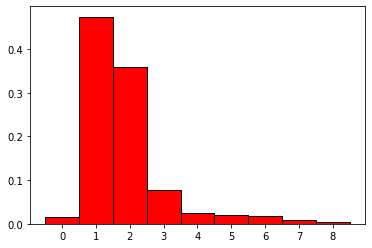

In [133]:
alphab = ['0', '1', '2', '3', '4', '5','6','7','8']
frequenciesC = [23,711,539,117,38 ,29,26,12,5]
total = np.sum(np.array(frequenciesC))
frequenciesC = frequenciesC/total

pos = np.arange(len(alphab))
ax = plot.axes()
ax.set_xticks(pos)
ax.set_xticklabels(alphab)

plot.bar(pos, frequenciesC, width, color='r', edgecolor='black')
plot.show()

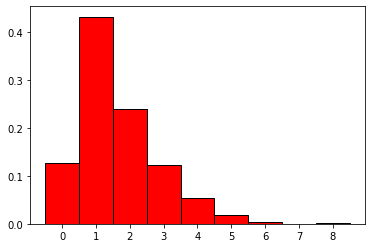

In [134]:

alphab = ['0', '1', '2', '3', '4', '5','6','7','8']
frequenciesW11 = [341,1163,647,329,147,50,10,1,3]
total = np.sum(np.array(frequenciesW11))
frequenciesW11 = frequenciesW11/total

pos = np.arange(len(alphab))
ax = plot.axes()
ax.set_xticks(pos)
ax.set_xticklabels(alphab)

plot.bar(pos, frequenciesW11, width, color='r', edgecolor='black')
plot.show()

In [45]:
x = np.prod(frequenciesC)
y = np.prod(frequenciesW11)
print(x)
print(y)
print(x/y)

4.388435183986987e-08
1.5147645580300604e-09
28.971071185439623


In [56]:
def bayesianEstimatorProb1(bsSpikes, stSpikes):
    x = bsSpikes[1]/np.sum(bsSpikes)
    y = stSpikes[1]/np.sum(stSpikes)
    #print(x)
    #print(y)

    return  1 -  x/y

In [51]:
print(bayesianEstimatorProb1(frequenciesC, frequenciesW11))

0.5315420560747663
0.466740988480119
-0.13883731918566555


In [52]:
def bayesianEstimatorMax(bsSpikes, stSpikes):
    index = np.argmax(stSpikes)
    
    x = bsSpikes[index]/np.sum(bsSpikes)
    y = stSpikes[index]/np.sum(stSpikes)
    print(x)
    print(y)

    return  1 -  x/y

In [53]:
print(bayesianEstimatorMax(frequenciesC, frequenciesW11))

0.5315420560747663
0.466740988480119
-0.13883731918566555


In [57]:
Z = []
prev = dataW11[0][0]
aux = []
for i in range(len(dataW11)):
    if dataW11[i][0] == prev:
        aux.append(bayesianEstimatorProb1(dataC[i][5],dataW11[i][5]))
    else:
        Z.append(aux)
        aux = []
        aux.append(bayesianEstimatorProb1(dataC[i][5],dataW11[i][5]))
    prev = dataW11[i][0]

Z.append(aux)
Z = np.array(Z)

In [59]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

dx, dy = 10, 10
y, x = np.mgrid[slice(10, 300 + dy, dy),
                slice(0, 100 + dx, dx)]

levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0) = plot.subplots(nrows=1)

im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('1_sin_60 bayesianEstimateProb1 W11')



fig.tight_layout()
plot.savefig("1_sin_60_W11.png", dpi=300)
plot.clf()

<Figure size 432x288 with 0 Axes>

In [ ]:
Z = []
prev = dataW11[0][0]
aux = []
for i in range(len(dataW11)):
    if dataW11[i][0] == prev:
        aux.append(bayesianEstimatorMax(dataC[i][5],dataW11[i][5]))
    else:
        Z.append(aux)
        aux = []
        aux.append(bayesianEstimatorMax(dataC[i][5],dataW11[i][5]))
    prev = dataW11[i][0]

Z.append(aux)
Z = np.array(Z)

dx, dy = 10, 10
y, x = np.mgrid[slice(10, 300 + dy, dy),
                slice(0, 100 + dx, dx)]

levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0) = plot.subplots(nrows=1)

im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('1_sin_60 bayesianEstimateMax W11')



fig.tight_layout()
plot.savefig("estimateMax.png", dpi=300)
plot.clf()

In [63]:
def bayesianEstimatorMaxNeighbours(bsSpikes, stSpikes):
    index = np.argmax(stSpikes)
    bsProbs = []
    stProbs = []
    bsProbs.append(bsSpikes[index]/np.sum(bsSpikes))
    stProbs.append(stSpikes[index]/np.sum(stSpikes))
    
    try:
        bsProbs.append(bsSpikes[index+1]/np.sum(bsSpikes))
    except:
        pass
    try:
        stProbs.append(stSpikes[index+1]/np.sum(stSpikes))
    except:
        pass
    try:
        bsProbs.append(bsSpikes[index-1]/np.sum(bsSpikes))
    except:
        pass
    try:
        stProbs.append(stSpikes[index-1]/np.sum(stSpikes))
    except:
        pass    
    print(bsProbs)
    print(stProbs)

    return  1 -  np.prod(bsProbs)/np.prod(stProbs)

In [ ]:
Z = []
prev = dataW11[0][0]
aux = []
for i in range(len(dataW11)):
    if dataW11[i][0] == prev:
        aux.append(bayesianEstimatorMaxNeighbours(dataC[i][5],dataW11[i][5]))
    else:
        Z.append(aux)
        aux = []
        aux.append(bayesianEstimatorMaxNeighbours(dataC[i][5],dataW11[i][5]))
    prev = dataW11[i][0]

Z.append(aux)
Z = np.array(Z)

dx, dy = 10, 10
y, x = np.mgrid[slice(10, 300 + dy, dy),
                slice(0, 100 + dx, dx)]

levels = MaxNLocator(nbins=15).tick_values(0, Z.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0) = plot.subplots(nrows=1)

im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('1_sin_60 bayesMaxNeighbours W11')



fig.tight_layout()
plot.savefig("prueba.png", dpi=300)
plot.clf()

In [68]:
print(bayesianEstimatorMaxNeighbours([1017,629,57,9], [1706,930,54,1]))

[0.5940420560747663, 0.36740654205607476, 0.005257009345794392]
[0.6339650687476774, 0.3455964325529543, 0.0003716090672612412]
-13.092302100247961


In [81]:
def bayesianEstimator(bsSpikes, stSpikes):
    baselineProbs = []
    stimulusProbs = []

    for i in range(len(stSpikes)):
        if stSpikes[i] != 0:
            try:
                baselineProbs.append(bsSpikes[i] / np.sum(bsSpikes))
            except IndexError:
                baselineProbs.append(0)
            stimulusProbs.append(stSpikes[i] / np.sum(stSpikes))
                
    y = np.prod(stimulusProbs)
    x = np.prod(baselineProbs)
    #print(1-x/y)

    return  1 -  x/y

Z = []
prev = dataW11[0][0]
aux = []
for i in range(len(dataW11)):
    if dataW11[i][0] == prev:
        aux.append(bayesianEstimator(dataC[i][5],dataW11[i][5]))
    else:
        Z.append(aux)
        aux = []
        aux.append(bayesianEstimator(dataC[i][5],dataW11[i][5]))
    prev = dataW11[i][0]

Z.append(aux)
Z = np.array(Z)

dx, dy = 10, 10
y, x = np.mgrid[slice(10, 300 + dy, dy),
                slice(0, 100 + dx, dx)]

levels = MaxNLocator(nbins=15).tick_values(0, Z.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0) = plot.subplots(nrows=1)

im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('1_sin_60 bayes W11')



fig.tight_layout()
plot.savefig("all_estimate_0min.png", dpi=300)
plot.clf()

<Figure size 432x288 with 0 Axes>

In [125]:
Z = []
prev = dataW11[0][0]
aux = []
for i in range(len(dataW11)):
    if dataW11[i][0] == prev:
        aux.append(bayesianEstimator(dataC[i][5],dataW11[i][5], 0.1))
    else:
        Z.append(aux)
        aux = []
        aux.append(bayesianEstimator(dataC[i][5],dataW11[i][5], 0.05))
    prev = dataW11[i][0]

Z.append(aux)
Z = np.array(Z)

dx, dy = 10, 10
y, x = np.mgrid[slice(10, 300 + dy, dy),
                slice(0, 100 + dx, dx)]

levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
cmap = plot.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0) = plot.subplots(nrows=1)

im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('1_sin_60 bayes W11')



fig.tight_layout()
plot.savefig("prueba10percent.png", dpi=300)
plot.clf()

<Figure size 432x288 with 0 Axes>

In [100]:
print(bayesianEstimator([1017,629,57,9], [1706,930,54,1], 0.1))

0
1
[0.5940420560747663, 0.36740654205607476]
[0.6339650687476774, 0.3455964325529543]
0.003839085196560066


In [108]:
print(impW11)

[1.08925049e+02 4.83187958e+02 7.12518982e+02 ... 6.98929188e+05
 6.99209938e+05 6.99443875e+05]


In [109]:
diffs = np.ediff1d(impW11)

In [118]:
diffs = np.ediff1d(impW11)
dif = []
for el in diffs:
    if el < 500:
        dif.append(el)


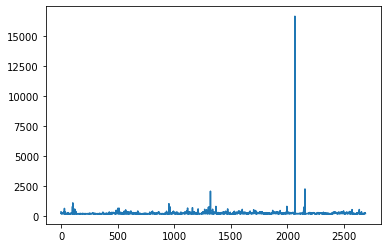

In [115]:
plot.plot(diffs)

In [291]:

plot.hist(dif, bins=100,density=True, stacked=True,ec='k')
plot.savefig('hist_tiempo_entre_estimulaciones.png')



NameError: name 'dif' is not defined

In [122]:
plot.clf()

<Figure size 432x288 with 0 Axes>

In [129]:
plot.clf()
sp.gaussian_kde(dif)
plot.show()

<Figure size 432x288 with 0 Axes>

In [141]:
print(bayesianEstimator([23,711,539,117,38 ,29,26,12,5],[341,1163,647,329,147,50,10,1,3], 0.1))

0
1
2
3
0.8734600827342917


In [ ]:
dataC1 = loadData("Desktop/Pececillos/data/C.dat.spkTimes", "Desktop/Pececillos/data/C1.dat.impulseTimes", 50, 150, 5)
dataW1 = loadData("Desktop/Pececillos/data/W1.dat.spkTimes", "Desktop/Pececillos/data/W1.dat.impulseTimes", 50, 150, 5)

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
train, test = train_test_split([1,2,3,4,5,6,7,8,9,10], test_size = 0.50)

In [168]:
print(train)

[5, 9, 3, 6, 2]


In [169]:
print(test)

[7, 10, 8, 4, 1]


In [173]:
print(spikesPerBin(spkC, impC, 150, 10))

[1 0 0 ... 2 1 0]


In [ ]:
dataCA = []
dataCB = []
for i in range(5, 151, 5):
    print("Vuelta " + str(i))
    for j in range(0, 51, 5):
        print("Subvuelta " + str(j))
        nspikesC = spikesPerBin(spkC, impC, i, j)
        nsCA, nsCB = train_test_split(nspikesC, test_size = 0.50)
        histA = np.bincount(nsCA)
        histB = np.bincount(nsCB)
        dataCA.append([i, j, histA])
        dataCB.append([i, j, histB])

In [217]:
def getHist(data, wLen, delay):
    for el in data:
        if el[0] == wLen and el[1] == delay:
            hist = el[-1]
    return hist   

In [218]:
def printHist(hist):
    alphab = []
    for i in range(len(hist)):
        alphab.append(str(i))
        
    frequencies = hist.tolist()
    total = np.sum(np.array(frequencies))
    frequencies = frequencies/total

    pos = np.arange(len(alphab))
    ax = plot.axes()
    ax.set_xticks(pos)
    ax.set_xticklabels(alphab)

    plot.bar(pos, frequencies, color='r', edgecolor='black')
    plot.show()

In [239]:
with open('dataCA.npy', 'rb') as f:
    dataCA = np.load(f, allow_pickle=True)
with open('dataCB.npy', 'rb') as f:
    dataCB = np.load(f, allow_pickle=True)

In [248]:
def bayesianEstimator(bsSpikes, stSpikes, umbral):
    baselineProbs = []
    stimulusProbs = []

    for i in range(len(stSpikes)):
        if i == 4:
            if stSpikes[i] != 0:
                if stSpikes[i]/np.sum(stSpikes) >= umbral:
                    #print(i)
                    stimulusProbs.append(stSpikes[i] / np.sum(stSpikes))
                    try:
                        baselineProbs.append(bsSpikes[i] / np.sum(bsSpikes))
                    except IndexError:
                        baselineProbs.append(0)
                    
    #print(baselineProbs)
    #print(stimulusProbs)
    y = np.prod(stimulusProbs)
    x = np.prod(baselineProbs)
    #print(1-x/y)

    return  1 -  x/y


In [237]:
def plotPcolor(dataC, dataW, umbral, xlen, ylen, despx, despy, title, filename):
    Z = []
    prev = dataW[0][0]
    aux = []
    for i in range(len(dataW)):
        if dataW[i][0] == prev:
            aux.append(bayesianEstimator(dataC[i][-1],dataW[i][-1], umbral))
        else:
            Z.append(aux)
            aux = []
            aux.append(bayesianEstimator(dataC[i][-1],dataW[i][-1], umbral))
        prev = dataW[i][0]

    Z.append(aux)
    Z = np.array(Z)
    Z[Z<0] = 0

    dx, dy = despx, despy
    y, x = np.mgrid[slice(despy, ylen + dy, dy),
                    slice(0, xlen + dx, dx)]

    levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
    cmap = plot.get_cmap('RdYlBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    im = plot.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
    plot.colorbar(im)
    plot.xlabel('Tamaño de ventana (T)')
    plot.ylabel('Desplazamiento de ventana (p)')
    plot.title(title)



    plot.tight_layout()
    plot.savefig(filename, dpi=300)
    plot.clf()
    
    return Z

In [249]:
plotPcolor(dataCA, dataCB, 0.05, 50, 150, 5, 5, "d=4 Baseline vs Baseline", "d4_BS_5pc.png")
#plotPcolor(dataC1, dataW1, 0.05, 50, 150, 5, 5, "total Baseline vs Palabra 1", "dtotal_W1_5pc.png")

0.010863104903479439

<Figure size 432x288 with 0 Axes>

In [23]:
with open('dataCA.npy', 'wb') as f:
    np.save(f, np.array(dataCA, dtype=object))
with open('dataCB.npy', 'wb') as f:
    np.save(f, np.array(dataCB, dtype=object))
with open('dataC1.npy', 'wb') as f:
    np.save(f, np.array(dataC1, dtype=object))
with open('dataW1.npy', 'wb') as f:
    np.save(f, np.array(dataW1, dtype=object))
with open('dataC11.npy', 'wb') as f:
    np.save(f, np.array(dataC11, dtype=object))
with open('dataW11.npy', 'wb') as f:
    np.save(f, np.array(dataW11, dtype=object))

In [212]:
#with open('dataCA.npy', 'rb') as f:
    #dataCA = np.load(f, allow_pickle=True)
#with open('dataCB.npy', 'rb') as f:
    #dataCB = np.load(f, allow_pickle=True)
with open('dataC1.npy', 'rb') as f:
    dataC1 = np.load(f, allow_pickle=True)
with open('dataW1.npy', 'rb') as f:
    dataW1 = np.load(f, allow_pickle=True)
with open('dataC11.npy', 'rb') as f:
    dataC11 = np.load(f, allow_pickle=True)
with open('dataW11.npy', 'rb') as f:
    dataW11 = np.load(f, allow_pickle=True)

In [18]:
meanC = plotPcolor(dataCA, dataCB, 0.05, 50, 150, 5, 5, "Baseline vs Baseline", "ge1_BSvsBS_5pc.png")
meanC1 = plotPcolor(dataC1, dataW1, 0.05, 50, 150, 5, 5, "Baseline vs W1", "ge1_BSvsW1_5pc.png")
meanC11 = plotPcolor(dataC11, dataW11, 0.05, 50, 150, 5, 5, "Baseline vs W11", "ge1_BSvsW11_5pc.png")

<Figure size 432x288 with 0 Axes>

In [13]:
print(meanC1)

0.10751100345334756


In [14]:
print(meanC11)

0.34366201525812534


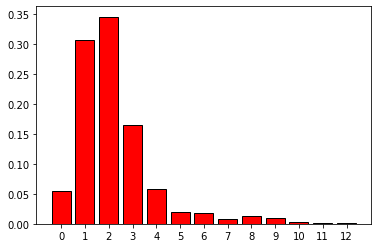

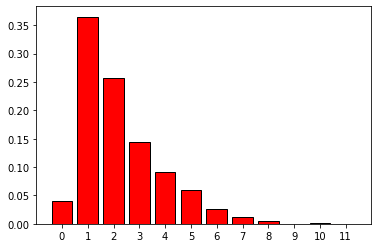

In [220]:
printHist(getHist(dataC11, 140, 45))
printHist(getHist(dataW11, 140, 45))
#bayesianEstimator(getHist(dataC11, 140, 30), getHist(dataW11, 140, 30), 0.05)

In [ ]:
meanC = plotPcolor(dataCA, dataCB, 0.025, 50, 150, 5, 5, "C vs C", "2p5percent_CvsC.png")
meanC1 = plotPcolor(dataC1, dataW1, 0.025, 50, 150, 5, 5, "C1 vs W1", "2p5percent_C1vsW1.png")
meanC11 = plotPcolor(dataC11, dataW11, 0.025, 50, 150, 5, 5, "C11 vs W11", "2p5percent_C11vsW11.png")

In [32]:
meanC = plotPcolor(dataCA, dataCB, 0.025, 50, 150, 5, 5, "C vs C", "S3plus_2p5percent_CvsC.png")
meanC1 = plotPcolor(dataC1, dataW1, 0.025, 50, 150, 5, 5, "C1 vs W1", "S3plus_2p5percent_C1vsW1.png")
meanC11 = plotPcolor(dataC11, dataW11, 0.025, 50, 150, 5, 5, "C11 vs W11", "S3plus_2p5percent_C11vsW11.png")

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [33]:
print(meanC, meanC1, meanC11)

0.03899145966250683 0.03698684022538383 0.4229256116997552


In [37]:
#meanC = plotPcolor(dataCA, dataCB, 0.05, 50, 150, 5, 5, "C vs C", "S1_5percent_CvsC.png")
meanC1 = plotPcolor(dataC1, dataW1, 0.05, 50, 150, 5, 5, "C1 vs W1", "S1_5percent_C1vsW1.png")
#meanC11 = plotPcolor(dataC11, dataW11, 0.05, 50, 150, 5, 5, "C11 vs W11", "S1_5percent_C11vsW11.png")

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
def plotPcolorNoneg(dataC, dataW, umbral, xlen, ylen, despx, despy, title, filename):
    Z = []
    prev = dataW[0][0]
    aux = []
    for i in range(len(dataW)):
        if dataW[i][0] == prev:
            aux.append(bayesianEstimator(dataC[i][-1],dataW[i][-1], umbral))
        else:
            Z.append(aux)
            aux = []
            aux.append(bayesianEstimator(dataC[i][-1],dataW[i][-1], umbral))
        prev = dataW[i][0]

    Z.append(aux)
    Z = np.array(Z)

    dx, dy = despx, despy
    y, x = np.mgrid[slice(despy, ylen + dy, dy),
                    slice(0, xlen + dx, dx)]
    
    Z2 = Z.clip(min=0)

    levels = MaxNLocator(nbins=15).tick_values(Z2.min(), Z2.max())
    cmap = plot.get_cmap('RdYlBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    fig, (ax0, ax1) = plot.subplots(nrows=2)

    im = ax0.pcolormesh(y, x, Z2, cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title(title)
    
    levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
    cmap = plot.get_cmap('RdYlBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    im2 = ax1.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
    fig.colorbar(im2, ax=ax1)
    ax1.set_title(title + 'with negatives')



    fig.tight_layout()
    plot.savefig(filename, dpi=300)
    plot.clf()
    
    return np.mean(Z)

In [56]:
meanC = plotPcolorNoneg(dataCA, dataCB, 0.1, 50, 150, 5, 5, "3S C vs C", "S3_10percent_CvsC.png")
meanC1 = plotPcolorNoneg(dataC1, dataW1, 0.1, 50, 150, 5, 5, "3S C1 vs W1", "S3_10percent_C1vsW1.png")
meanC11 = plotPcolorNoneg(dataC11, dataW11, 0.1, 50, 150, 5, 5, "3S C11 vs W11", "S3_10percent_C11vsW11.png")
meanC = plotPcolorNoneg(dataCA, dataCB, 0.01, 50, 150, 5, 5, "3S C vs C", "S3_01percent_CvsC.png")
meanC1 = plotPcolorNoneg(dataC1, dataW1, 0.01, 50, 150, 5, 5, "3S C1 vs W1", "S3_01percent_C1vsW1.png")
meanC11 = plotPcolorNoneg(dataC11, dataW11, 0.01, 50, 150, 5, 5, "3S C11 vs W11", "S3_01percent_C11vsW11.png")
meanC = plotPcolorNoneg(dataCA, dataCB, 0, 50, 150, 5, 5, "3S C vs C", "S3_05percent_CvsC.png")
meanC1 = plotPcolorNoneg(dataC1, dataW1, 0, 50, 150, 5, 5, "3S C1 vs W1", "S3_05percent_C1vsW1.png")
meanC11 = plotPcolorNoneg(dataC11, dataW11, 0, 50, 150, 5, 5, "3S C11 vs W11", "S3_05percent_C11vsW11.png")

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [33]:
meanC = plotPcolor(dataCA, dataCB, 0.05, 50, 150, 5, 5, "ge1 Baseline vs Baseline", "ge1_CvsC.png")
meanC1 = plotPcolor(dataC1, dataW1, 0.05, 50, 150, 5, 5, "ge1 Baseline vs Palabra 1", "ge1_C1vsW1.png")
meanC11 = plotPcolor(dataC11, dataW11, 0.05, 50, 150, 5, 5, "ge1 Baseline vs Palabra 11", "ge1_C11vsW11.png")

<Figure size 432x288 with 0 Axes>

In [3]:
impC11 = np.loadtxt("Desktop/Pececillos/data/1_sin_60/C11.dat.impulseTimes", delimiter=" ")
impW11 = np.loadtxt("Desktop/Pececillos/data/1_sin_60/W11_recortado.dat.impulseTimes", delimiter=" ")
impC1 = np.loadtxt("Desktop/Pececillos/data/C1.dat.impulseTimes", delimiter=" ")
impW1 = np.loadtxt("Desktop/Pececillos/data/W1.dat.impulseTimes", delimiter=" ")

In [56]:
spkC11 = np.loadtxt("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", delimiter=" ")
spkW11 = np.loadtxt("Desktop/Pececillos/data/1_sin_60/W11_recortado.dat.spkTimes", delimiter=" ")
spkC1 = np.loadtxt("Desktop/Pececillos/data/C.dat.spkTimes", delimiter=" ")
spkW1 = np.loadtxt("Desktop/Pececillos/data/W1.dat.spkTimes", delimiter=" ")

In [354]:
def getISI(imp):
    diffs = np.ediff1d(imp)
    dif = []
    for el in diffs:
        if el < 500:
            dif.append(el)
    return dif

In [58]:
isiC11 = getISI(spkC11)
isiW11 = getISI(spkW11)
isiC1 = getISI(spkC1)
isiW1 = getISI(spkW1)

In [355]:
def plotISIhist(isiC, isiW, title, clabel, wlabel, filename):    
    plot.hist(isiC, bins=100, alpha=0.5, density=True, stacked=True, ec='r', label=clabel, histtype='step')
    plot.hist(isiW, bins=100, alpha=0.5, density=True, stacked=True, ec='b', label=wlabel, histtype='step')
    plot.xlabel('ms')
    plot.legend(loc='upper right')
    plot.title(title)
    plot.savefig(filename, dpi=300)
    plot.clf()

In [356]:
plotISIhist(isiC1, isiW1, 'IPI', 'Baseline', 'Palabra 1', 'IPI_C1vsW1.png')
plotISIhist(isiC11, isiW11, 'IPI', 'Baseline', 'Palabra 11', 'IPI_C11vsW11.png')

<Figure size 432x288 with 0 Axes>

In [215]:
def bayesianEstimator(bsSpikes, stSpikes, umbral):
    baselineProbs = []
    stimulusProbs = []

    for i in range(len(stSpikes)):
        if i == 0:
            if stSpikes[i] != 0:
                if stSpikes[i]/np.sum(stSpikes) >= umbral:
                    #print(i)
                    stimulusProbs.append(stSpikes[i] / np.sum(stSpikes))
                    try:
                        baselineProbs.append(bsSpikes[i] / np.sum(bsSpikes))
                    except IndexError:
                        baselineProbs.append(0)
                    
    #print(baselineProbs)
    #print(stimulusProbs)
    y = np.prod(stimulusProbs)
    x = np.prod(baselineProbs)
    #print(1-x/y)

    return  1 -  x/y

In [216]:
#meanC = plotPcolor(dataCA, dataCB, 0, 50, 150, 5, 5, "s=0 Baseline vs Baseline", "S0_CvsC.png")
meanC1 = plotPcolor(dataC1, dataW1, 0.05, 50, 150, 5, 5, "s=0 Baseline vs Palabra 1", "PRUEBA_S0_C1vsW1.png")
meanC11 = plotPcolor(dataC11, dataW11, 0.05, 50, 150, 5, 5, "s=0 Baseline vs Palabra 11", "PRUEBA_S0_C11vsW11.png")

<Figure size 432x288 with 0 Axes>

In [46]:
#meanC = plotPcolor(dataCA, dataCB, 0, 50, 150, 5, 5, "s=1 Baseline vs Baseline", "S1_CvsC.png")
meanC1 = plotPcolor(dataC1, dataW1, 0, 50, 150, 5, 5, "s=1 Baseline vs Palabra 1", "prueba2S1_C1vsW1.png")
#meanC11 = plotPcolor(dataC11, dataW11, 0, 50, 150, 5, 5, "s=1 Baseline vs Palabra 11", "S1_C11vsW11.png")

<Figure size 432x288 with 0 Axes>

In [48]:
meanC = plotPcolor(dataCA, dataCB, 0, 50, 150, 5, 5, "s=2aseline vs Baseline", "S2_CvsC.png")
meanC1 = plotPcolor(dataC1, dataW1, 0, 50, 150, 5, 5, "s=2 Baseline vs Palabra 1", "S2_C1vsW1.png")
meanC11 = plotPcolor(dataC11, dataW11, 0, 50, 150, 5, 5, "s=2 Baseline vs Palabra 11", "S2_C11vsW11.png")

<Figure size 432x288 with 0 Axes>

In [51]:
meanC = plotPcolor(dataCA, dataCB, 0, 50, 150, 5, 5, "s=3 Baseline vs Baseline", "S3_CvsC.png")
meanC1 = plotPcolor(dataC1, dataW1, 0, 50, 150, 5, 5, "s=3 Baseline vs Palabra 1", "S3_C1vsW1.png")
meanC11 = plotPcolor(dataC11, dataW11, 0, 50, 150, 5, 5, "s=3 Baseline vs Palabra 11", "S3_C11vsW11.png")

<Figure size 432x288 with 0 Axes>

In [53]:
meanC = plotPcolor(dataCA, dataCB, 0, 50, 150, 5, 5, "s=4 Baseline vs Baseline", "S4_CvsC.png")
meanC1 = plotPcolor(dataC1, dataW1, 0, 50, 150, 5, 5, "s=4 Baseline vs Palabra 1", "S4_C1vsW1.png")
meanC11 = plotPcolor(dataC11, dataW11, 0, 50, 150, 5, 5, "s=4 Baseline vs Palabra 11", "S4_C11vsW11.png")

<Figure size 432x288 with 0 Axes>

In [75]:
def loadDataSplit(spkfile, impfile):
    dataCA = []
    dataCB = []
    spkC = np.loadtxt(spkfile, delimiter=" ")
    impC = np.loadtxt(impfile, delimiter=" ")
    for i in range(5, 151, 5):
        print("Vuelta " + str(i))
        for j in range(0, 51, 5):
            print("Subvuelta " + str(j))
            nspikesC = spikesPerBin(spkC, impC, i, j)
            nsCA, nsCB = train_test_split(nspikesC, test_size = 0.50)
            histA = np.bincount(nsCA)
            histB = np.bincount(nsCB)
            dataCA.append([i, j, histA])
            dataCB.append([i, j, histB])
    
    return dataCA, dataCB

        

In [ ]:
dataCA, dataCB = loadDataSplit("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/C11.dat.impulseTimes")
dataCC, dataCD = loadDataSplit("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/C11.dat.impulseTimes")
dataCE, dataCF = loadDataSplit("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/C11.dat.impulseTimes")
dataCG, dataCH = loadDataSplit("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/C11.dat.impulseTimes")
dataCI, dataCJ = loadDataSplit("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/C11.dat.impulseTimes")

In [211]:
with open('dataCA2.npy', 'wb') as f:
    np.save(f, np.array(dataCA, dtype=object))
with open('dataCB2.npy', 'wb') as f:
    np.save(f, np.array(dataCB, dtype=object))
with open('dataCC.npy', 'wb') as f:
    np.save(f, np.array(dataCC, dtype=object))
with open('dataCD.npy', 'wb') as f:
    np.save(f, np.array(dataCD, dtype=object))
with open('dataCE.npy', 'wb') as f:
    np.save(f, np.array(dataCE, dtype=object))
with open('dataCF.npy', 'wb') as f:
    np.save(f, np.array(dataCF, dtype=object))
with open('dataCG.npy', 'wb') as f:
    np.save(f, np.array(dataCG, dtype=object))
with open('dataCH.npy', 'wb') as f:
    np.save(f, np.array(dataCH, dtype=object))
with open('dataCI.npy', 'wb') as f:
    np.save(f, np.array(dataCI, dtype=object))
with open('dataCJ.npy', 'wb') as f:
    np.save(f, np.array(dataCJ, dtype=object))

In [ ]:
with open('dataCA.npy', 'rb') as f:
    dataCA = np.load(f, allow_pickle=True)
with open('dataCB.npy', 'rb') as f:
    dataCB = np.load(f, allow_pickle=True)
with open('dataCA.npy', 'rb') as f:
    dataCA = np.load(f, allow_pickle=True)
with open('dataCB.npy', 'rb') as f:
    dataCB = np.load(f, allow_pickle=True)
with open('dataCA.npy', 'rb') as f:
    dataCA = np.load(f, allow_pickle=True)
with open('dataCB.npy', 'rb') as f:
    dataCB = np.load(f, allow_pickle=True)
with open('dataCA.npy', 'rb') as f:
    dataCA = np.load(f, allow_pickle=True)
with open('dataCB.npy', 'rb') as f:
    dataCB = np.load(f, allow_pickle=True)
with open('dataCA.npy', 'rb') as f:
    dataCA = np.load(f, allow_pickle=True)
with open('dataCB.npy', 'rb') as f:
    dataCB = np.load(f, allow_pickle=True)

In [199]:
def getZvalues(dataC, dataW, umbral):
    Z = []
    prev = dataW[0][0]
    aux = []
    for i in range(len(dataW)):
        if dataW[i][0] == prev:
            aux.append(bayesianEstimator(dataC[i][-1],dataW[i][-1], umbral))
        else:
            Z.append(aux)
            aux = []
            aux.append(bayesianEstimator(dataC[i][-1],dataW[i][-1], umbral))
        prev = dataW[i][0]
    
    Z.append(aux)
    return np.array(Z)

In [200]:
#s=0 values
zA = getZvalues(dataCA, dataCB, 0.05)
zB = getZvalues(dataCC, dataCD, 0.05)
zC = getZvalues(dataCE, dataCF, 0.05)
zD = getZvalues(dataCG, dataCH, 0.05)
zE = getZvalues(dataCI, dataCJ, 0.05)

In [201]:
zvalues = (zA + zB + zC + zD + zE)/5


In [202]:
def plotPcolor(Z, xlen, ylen, despx, despy, title, filename):
    #Z2 = Z.clip(min=0)
    Z[Z<0] = 0

    dx, dy = despx, despy
    y, x = np.mgrid[slice(despy, ylen + dy, dy),
                    slice(0, xlen + dx, dx)]

    levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
    cmap = plot.get_cmap('RdYlBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    #fig, (ax0) = plot.subplots(nrows=1)

    im = plot.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
    #fig.colorbar(im, ax=ax0)
    plot.colorbar(im)
    plot.xlabel('Tamaño de ventana (T)')
    plot.ylabel('Desplazamiento de ventana (p)')
    plot.title(title)



    plot.tight_layout()
    plot.savefig(filename, dpi=300)
    plot.clf()
    
    return np.mean(Z)

In [203]:
plotPcolor(zvalues, 50, 150, 5, 5, "prueba Baseline vs Baseline", "mean4_prueba_CvsC.png")

0.0066665610957152375

<Figure size 432x288 with 0 Axes>

In [153]:
rawData = np.loadtxt("Desktop/1_sin_60/19h53m19s-09-sep-2014.dat", delimiter=" ")

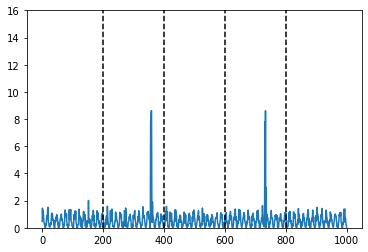

In [259]:
plot.plot(rawData[20000:21000,3])
plot.axvline(x=200, color='k', ls='--')
plot.axvline(x=400, color='k', ls='--')
plot.axvline(x=600, color='k', ls='--')
plot.axvline(x=800, color='k', ls='--')
plot.ylim([0,16])
plot.savefig("protocolo2.png", dpi=300)

In [174]:
meanC11 = plotPcolor(dataC11, dataW11, 0.05, 50, 150, 5, 5, "Baseline vs W11", "mean_prueba2_ge1_BSvsW11_5pc.png")

<Figure size 432x288 with 0 Axes>

In [ ]:
dataC1B = loadData("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/C1.dat.impulseTimes", 50, 150, 5)
dataW1B = loadData("Desktop/Pececillos/data/1_sin_60/W1.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/W1.dat.impulseTimes", 50, 150, 5)

In [263]:
with open('dataC1B.npy', 'wb') as f:
    np.save(f, np.array(dataC1B, dtype=object))
with open('dataW1B.npy', 'wb') as f:
    np.save(f, np.array(dataW1B, dtype=object))

In [379]:
def plotPcolorHist(dataC, dataW, umbral, xlen, ylen, despx, despy, title, filename):
    Z = []
    prev = dataW[0][0]
    aux = []
    for i in range(len(dataW)):
        if dataW[i][0] == prev:
            aux.append(bayesianEstimator(dataC[i][-1],dataW[i][-1], umbral))
        else:
            Z.append(aux)
            aux = []
            aux.append(bayesianEstimator(dataC[i][-1],dataW[i][-1], umbral))
        prev = dataW[i][0]

    Z.append(aux)
    Z = np.array(Z)
    Z[Z<0] = 0

    dx, dy = despx, despy
    y, x = np.mgrid[slice(despy, ylen + dy, dy),
                    slice(0, xlen + dx, dx)]

    levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
    cmap = plot.get_cmap('RdYlBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    fig, (ax0, ax1) = plot.subplots(1, 2)
    fig.set_figwidth(8)
    
    im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title(title)
    ax0.set(xlabel='Tamaño de ventana (T)', ylabel='Desplazamiento de ventana (p)')

    Z = Z[Z != 0].flatten()
    sns.histplot(Z, element="bars", stat="probability", ax=ax1)
    ax1.set_title('Histograma de respuestas')
    ax1.set(ylabel='')

    plot.tight_layout()
    plot.savefig(filename, dpi=300)
    plot.clf()
    
    return Z[np.argsort(Z)]

In [406]:
def bayesianEstimator(bsSpikes, stSpikes, umbral):
    baselineProbs = []
    stimulusProbs = []

    for i in range(len(stSpikes)):
        if i >= 0:
            if stSpikes[i] != 0:
                if stSpikes[i]/np.sum(stSpikes) >= umbral:
                    #print(i)
                    stimulusProbs.append(stSpikes[i] / np.sum(stSpikes))
                    try:
                        baselineProbs.append(bsSpikes[i] / np.sum(bsSpikes))
                    except IndexError:
                        baselineProbs.append(0)
                    
    #print(baselineProbs)
    #print(stimulusProbs)
    y = np.prod(stimulusProbs)
    x = np.prod(baselineProbs)
    #print(1-x/y)

    return  1 -  x/y

In [407]:
C = plotPcolorHist(dataCA, dataCB, 0.05, 50, 150, 5, 5, "total Baseline vs Baseline", "dtotal_BS_5pc.png")
W1= plotPcolorHist(dataC1, dataW1, 0.05, 50, 150, 5, 5, "total Baseline vs Palabra 1", "dtotal_W1_5pc.png")
W1B = plotPcolorHist(dataC1B, dataW1B, 0.05, 50, 150, 5, 5, "total Baseline vs Palabra 1", "dtotal_W1B_5pc.png")
W11 = plotPcolorHist(dataC11, dataW11, 0.05, 50, 150, 5, 5, "total Baseline vs Palabra 11", "dtotal_W11_5pc.png")

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [408]:
print(np.mean(C[-5:]))
print(np.mean(W1[-5:]))
print(np.mean(W11[-5:]))
print(np.mean(W1B[-5:]))

0.32014412994061137
0.4615515048987097
0.7317325297841617
0.8294271670223281


In [370]:
spkC = np.loadtxt("Desktop/Pececillos/data/1_sin_60/W1.dat.spkTimes", delimiter=" ")
spkW = np.loadtxt("Desktop/Pececillos/data/1_sin_60/W11_recortado.dat.spkTimes", delimiter=" ")

In [371]:
isiC1 = getISI(spkC)
isiW1 = getISI(spkW)

In [372]:
plotISIhist(isiC1, isiW1, 'IPI', 'Baseline', 'Palabra 1', 'F2IPI_C1vsW11111.png')

<Figure size 432x288 with 0 Axes>

In [412]:
def plotISIhist(isiC, isiW, isiW2, title, clabel, wlabel, w2label, filename):    
    plot.hist(isiC, bins=100, alpha=0.5, density=True, stacked=True, ec='r', label=clabel, histtype='step')
    plot.hist(isiW, bins=100, alpha=0.5, density=True, stacked=True, ec='b', label=wlabel, histtype='step')
    plot.hist(isiW2, bins=100, alpha=0.5, density=True, stacked=True, ec='g', label=w2label, histtype='step')
    plot.xlabel('ms')
    plot.legend(loc='upper right')
    plot.title(title)
    plot.savefig(filename, dpi=300)
    plot.clf()

In [410]:
spkW2= np.loadtxt("Desktop/Pececillos/data/1_sin_60/W1.dat.spkTimes", delimiter=" ")
spkW = np.loadtxt("Desktop/Pececillos/data/1_sin_60/W11_recortado.dat.spkTimes", delimiter=" ")
spkC = np.loadtxt("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", delimiter=" ")

In [411]:
isiC1 = getISI(spkC)
isiW1 = getISI(spkW2)
isiW11 = getISI(spkW)

In [413]:
plotISIhist(isiC1, isiW11, isiW1, 'IPI', 'Baseline', 'Palabra 11', 'Palabra 1','F3IPI_C1vsW11111.png')

<Figure size 432x288 with 0 Axes>